In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install scikit-optimize

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 5.6 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
import tensorflow as tf
from tensorflow.keras.models import Sequential, save_model, load_model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from skopt import gp_minimize
from skopt.space import Real, Integer
from sklearn.model_selection import KFold
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard
import datetime
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
from scipy import stats

In [ ]:
df=pd.read_csv("/content/drive/MyDrive/shuffled_data.csv")

In [ ]:
print(df.dtypes)


AGE                float64
SEX                  int64
CATEGORY_NAME      float64
SURGERY            float64
VILLAGE            float64
PREAUTH_AMT        float64
CLAIM_AMOUNT         int64
HOSP_NAME          float64
HOSP_TYPE            int64
HOSP_LOCATION      float64
Mortality Y / N      int64
dtype: object


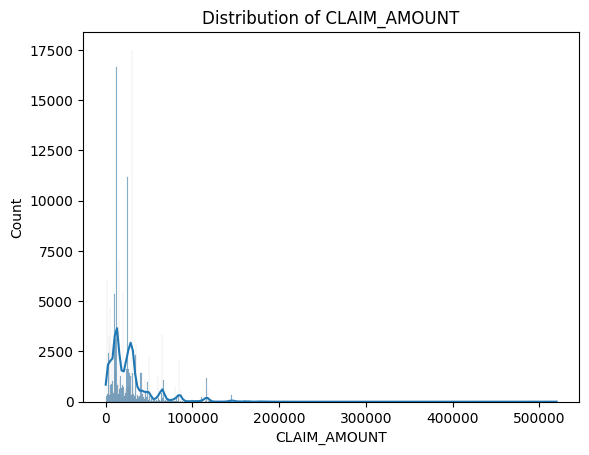

Skewness: 2.928409545513503
Applied log transformation.


In [ ]:
# Visualize target distribution
sns.histplot(df['CLAIM_AMOUNT'], kde=True)
plt.title('Distribution of CLAIM_AMOUNT')
plt.show()

# Check skewness
skewness = df['CLAIM_AMOUNT'].skew()
print(f"Skewness: {skewness}")

# Apply log transformation if skewness > 1 or < -1
if abs(skewness) > 1:
    df['CLAIM_AMOUNT'] = np.log1p(df['CLAIM_AMOUNT'])
    print("Applied log transformation.")


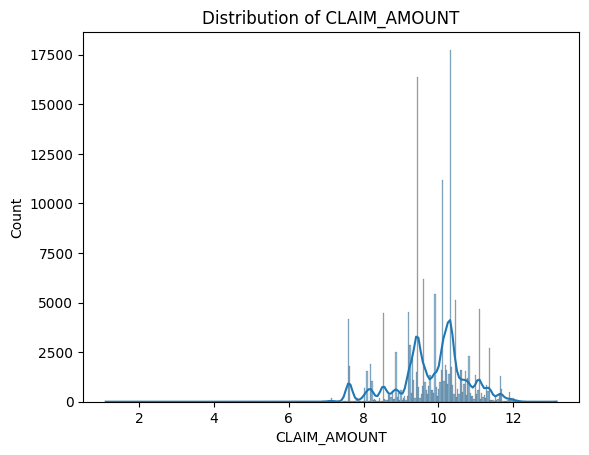

In [ ]:
sns.histplot(df['CLAIM_AMOUNT'], kde=True)
plt.title('Distribution of CLAIM_AMOUNT')
plt.show()


In [ ]:
os.makedirs('saved_models', exist_ok=True)

In [ ]:
# Separate features and target
X = df.drop('CLAIM_AMOUNT', axis=1)
y = df['CLAIM_AMOUNT']

# Train-validation-test split (60%-20%-20%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42,shuffle=True)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42,shuffle=True)

# Feature Scaling
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# PCA Dimensionality Reduction (retain 95% variance)
pca = PCA(n_components=0.95, random_state=42)
X_train_pca = pca.fit_transform(X_train_scaled)
X_val_pca = pca.transform(X_val_scaled)
X_test_pca = pca.transform(X_test_scaled)

print(f"PCA reduced dimensions from {X.shape[1]} to {X_train_pca.shape[1]}")

# Save preprocessed data
np.save('saved_models/X_train_pca.npy', X_train_pca)
np.save('saved_models/X_val_pca.npy', X_val_pca)
np.save('saved_models/X_test_pca.npy', X_test_pca)
np.save('saved_models/y_train.npy', y_train.values)
np.save('saved_models/y_val.npy', y_val.values)
np.save('saved_models/y_test.npy', y_test.values)


PCA reduced dimensions from 10 to 6


In [ ]:
# Configure GPU
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    try:
        # Allow memory growth for the GPU
        for device in physical_devices:
            tf.config.experimental.set_memory_growth(device, True)
        print(f"GPU is available: {len(physical_devices)} device(s) found")
    except RuntimeError as e:
        print(f"GPU configuration error: {e}")
else:
    print("No GPU found, using CPU instead")

def build_model(hp):
    model = Sequential()
    model.add(Dense(hp['units1'], activation='relu', kernel_regularizer=l2(hp['l2']),
                   input_shape=(X_train_pca.shape[1],)))
    model.add(BatchNormalization())
    model.add(Dropout(hp['dropout']))

    model.add(Dense(hp['units2'], activation='relu', kernel_regularizer=l2(hp['l2'])))
    model.add(BatchNormalization())
    model.add(Dropout(hp['dropout']))

    model.add(Dense(hp['units3'], activation='relu', kernel_regularizer=l2(hp['l2'])))
    model.add(BatchNormalization())
    model.add(Dropout(hp['dropout']))

    model.add(Dense(hp['units4'], activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(hp['dropout'] * 0.8))  # Slightly less dropout in deeper layers

    model.add(Dense(1, activation='linear'))

    optimizer = tf.keras.optimizers.Adam(learning_rate=hp['learning_rate'])
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

    return model


GPU is available: 1 device(s) found


In [ ]:
# Define hyperparameter search space
search_space = [
    Integer(64, 256, name='units1'),
    Integer(32, 128, name='units2'),
    Integer(16, 64, name='units3'),
    Integer(8, 32, name='units4'),
    Real(1e-4, 1e-2, "log-uniform", name='learning_rate'),
    Real(1e-5, 1e-3, "log-uniform", name='l2'),
    Real(0.1, 0.5, name='dropout')
]

# Objective function for Bayesian optimization with cross-validation
def objective(params):
    hp = {
        'units1': params[0],
        'units2': params[1],
        'units3': params[2],
        'units4': params[3],
        'learning_rate': params[4],
        'l2': params[5],
        'dropout': params[6]
    }

    kf = KFold(n_splits=3)
    val_losses = []

    for fold, (train_idx, val_idx) in enumerate(kf.split(X_train_pca)):
        X_tr, X_va = X_train_pca[train_idx], X_train_pca[val_idx]
        y_tr, y_va = y_train.iloc[train_idx], y_train.iloc[val_idx]

        # Clear previous model from memory
        tf.keras.backend.clear_session()

        model = build_model(hp)

        # Create callbacks
        early_stop = EarlyStopping(
            monitor='val_loss',
            patience=7,
            restore_best_weights=True
        )

        lr_scheduler = ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=4,
            min_lr=1e-6
        )

        # Checkpoint to save best model for this fold
        checkpoint = ModelCheckpoint(
            f'saved_models/temp_model_fold_{fold}.h5',
            monitor='val_loss',
            save_best_only=True,
            verbose=0
        )

        history = model.fit(
            X_tr, y_tr,
            epochs=50,
            batch_size=32,
            validation_data=(X_va, y_va),
            callbacks=[early_stop, lr_scheduler, checkpoint],
            verbose=0
        )

        val_loss = min(history.history['val_loss'])
        val_losses.append(val_loss)

    avg_val_loss = np.mean(val_losses)

    print(f"Params: {hp}, Val Loss: {avg_val_loss:.4f}")

    return avg_val_loss

# Run Bayesian optimization
print("Starting Bayesian optimization...")
opt_results = gp_minimize(
    objective,
    search_space,
    n_calls=10,
    random_state=42,
    verbose=True
)

best_hp_values = {
    'units1': opt_results.x[0],
    'units2': opt_results.x[1],
    'units3': opt_results.x[2],
    'units4': opt_results.x[3],
    'learning_rate': opt_results.x[4],
    'l2': opt_results.x[5],
    'dropout': opt_results.x[6]
}

print("Best Hyperparameters:", best_hp_values)



Starting Bayesian optimization...
Iteration No: 1 started. Evaluating function at random point.


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Params: {'units1': np.int64(217), 'units2': np.int64(50), 'units3': np.int64(53), 'units4': np.int64(22), 'learning_rate': 0.0007792297153882995, 'l2': 1.584710121043908e-05, 'dropout': 0.28369955678634695}, Val Loss: 0.0754
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 495.9860
Function value obtained: 0.0754
Current minimum: 0.0754
Iteration No: 2 started. Evaluating function at random point.


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Params: {'units1': np.int64(128), 'units2': np.int64(46), 'units3': np.int64(47), 'units4': np.int64(9), 'learning_rate': 0.0027796975515266826, 'l2': 0.0007535384509295551, 'dropout': 0.10031150633640573}, Val Loss: 0.0735
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 808.8969
Function value obtained: 0.0735
Current minimum: 0.0735
Iteration No: 3 started. Evaluating function at random point.


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Params: {'units1': np.int64(255), 'units2': np.int64(91), 'units3': np.int64(45), 'units4': np.int64(8), 'learning_rate': 0.00011120513715710631, 'l2': 0.00011208547084229366, 'dropout': 0.25994438868610226}, Val Loss: 0.1243
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 918.1804
Function value obtained: 0.1243
Current minimum: 0.0735
Iteration No: 4 started. Evaluating function at random point.


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Params: {'units1': np.int64(73), 'units2': np.int64(125), 'units3': np.int64(27), 'units4': np.int64(10), 'learning_rate': 0.0017249321573178998, 'l2': 5.820013372709849e-05, 'dropout': 0.49329235432271534}, Val Loss: 0.0861
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 594.6742
Function value obtained: 0.0861
Current minimum: 0.0735
Iteration No: 5 started. Evaluating function at random point.


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Params: {'units1': np.int64(154), 'units2': np.int64(115), 'units3': np.int64(49), 'units4': np.int64(19), 'learning_rate': 0.00010629918194937633, 'l2': 0.0007663082680255858, 'dropout': 0.3253152871382158}, Val Loss: 0.0906
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 1002.9591
Function value obtained: 0.0906
Current minimum: 0.0735
Iteration No: 6 started. Evaluating function at random point.


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Params: {'units1': np.int64(138), 'units2': np.int64(34), 'units3': np.int64(27), 'units4': np.int64(14), 'learning_rate': 0.0023255572624036797, 'l2': 0.00016595613641357258, 'dropout': 0.4332779646944659}, Val Loss: 0.0864
Iteration No: 6 ended. Evaluation done at random point.
Time taken: 434.7727
Function value obtained: 0.0864
Current minimum: 0.0735
Iteration No: 7 started. Evaluating function at random point.


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Params: {'units1': np.int64(97), 'units2': np.int64(70), 'units3': np.int64(25), 'units4': np.int64(26), 'learning_rate': 0.0007084541505250234, 'l2': 2.6054534945803984e-05, 'dropout': 0.3270801311279966}, Val Loss: 0.0783
Iteration No: 7 ended. Evaluation done at random point.
Time taken: 488.0937
Function value obtained: 0.0783
Current minimum: 0.0735
Iteration No: 8 started. Evaluating function at random point.


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Params: {'units1': np.int64(70), 'units2': np.int64(113), 'units3': np.int64(38), 'units4': np.int64(17), 'learning_rate': 0.007133747470888437, 'l2': 0.00028480262754225174, 'dropout': 0.2306163075223342}, Val Loss: 0.0809
Iteration No: 8 ended. Evaluation done at random point.
Time taken: 573.2419
Function value obtained: 0.0809
Current minimum: 0.0735
Iteration No: 9 started. Evaluating function at random point.


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Params: {'units1': np.int64(174), 'units2': np.int64(82), 'units3': np.int64(62), 'units4': np.int64(28), 'learning_rate': 0.003123490722120777, 'l2': 0.00012005610926192105, 'dropout': 0.33470046626553934}, Val Loss: 0.0761
Iteration No: 9 ended. Evaluation done at random point.
Time taken: 710.4642
Function value obtained: 0.0761
Current minimum: 0.0735
Iteration No: 10 started. Evaluating function at random point.


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Params: {'units1': np.int64(249), 'units2': np.int64(90), 'units3': np.int64(29), 'units4': np.int64(15), 'learning_rate': 0.00021405919019849062, 'l2': 1.0746642789365072e-05, 'dropout': 0.26936059228254794}, Val Loss: 0.0856
Iteration No: 10 ended. Evaluation done at random point.
Time taken: 615.6710
Function value obtained: 0.0856
Current minimum: 0.0735
Best Hyperparameters: {'units1': np.int64(128), 'units2': np.int64(46), 'units3': np.int64(47), 'units4': np.int64(9), 'learning_rate': 0.0027796975515266826, 'l2': 0.0007535384509295551, 'dropout': 0.10031150633640573}


In [ ]:
# Convert NumPy types to native Python types
best_hp_values = {k: (int(v) if isinstance(v, np.integer) else float(v) if isinstance(v, np.floating) else v)
                  for k, v in best_hp_values.items()}

# Save best hyperparameters
import json
with open('saved_models/best_hyperparameters.json', 'w') as f:
    json.dump(best_hp_values, f)


In [ ]:
# Clear session for final model
tf.keras.backend.clear_session()

# Build final model with best hyperparameters
final_model = build_model(best_hp_values)

# Setup TensorBoard logging
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

# Callbacks for final model
early_stop_final = EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True,
    verbose=1
)

lr_scheduler_final = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-6,
    verbose=1
)

# Save best model during training
model_checkpoint = ModelCheckpoint(
    'saved_models/best_model.h5',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

# Train final model
history_final = final_model.fit(
    X_train_pca,
    y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_val_pca, y_val),
    callbacks=[early_stop_final, lr_scheduler_final, model_checkpoint, tensorboard_callback],
    verbose=1
)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
2813/2813 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 18.7927 - mae: 2.8091
Epoch 1: val_loss improved from inf to 0.16014, saving model to saved_models/best_model.h5


2813/2813 ━━━━━━━━━━━━━━━━━━━━ 23s 6ms/step - loss: 18.7880 - mae: 2.8086 - val_loss: 0.1601 - val_mae: 0.2439 - learning_rate: 0.0028
Epoch 2/100
2805/2813 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.9210 - mae: 0.7488
Epoch 2: val_loss improved from 0.16014 to 0.10956, saving model to saved_models/best_model.h5


2813/2813 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - loss: 0.9208 - mae: 0.7487 - val_loss: 0.1096 - val_mae: 0.1963 - learning_rate: 0.0028
Epoch 3/100
2808/2813 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6576 - mae: 0.6402
Epoch 3: val_loss did not improve from 0.10956
2813/2813 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - loss: 0.6575 - mae: 0.6401 - val_loss: 0.1147 - val_mae: 0.2282 - learning_rate: 0.0028
Epoch 4/100
2800/2813 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4334 - mae: 0.5087
Epoch 4: val_loss improved from 0.10956 to 0.09094, saving model to saved_models/best_model.h5


2813/2813 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - loss: 0.4332 - mae: 0.5086 - val_loss: 0.0909 - val_mae: 0.1709 - learning_rate: 0.0028
Epoch 5/100
2801/2813 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2960 - mae: 0.4071
Epoch 5: val_loss improved from 0.09094 to 0.08636, saving model to saved_models/best_model.h5


2813/2813 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - loss: 0.2959 - mae: 0.4070 - val_loss: 0.0864 - val_mae: 0.1716 - learning_rate: 0.0028
Epoch 6/100
2807/2813 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2124 - mae: 0.3366
Epoch 6: val_loss did not improve from 0.08636
2813/2813 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - loss: 0.2124 - mae: 0.3366 - val_loss: 0.0960 - val_mae: 0.1822 - learning_rate: 0.0028
Epoch 7/100
2804/2813 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1771 - mae: 0.3014
Epoch 7: val_loss did not improve from 0.08636
2813/2813 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - loss: 0.1771 - mae: 0.3014 - val_loss: 0.0892 - val_mae: 0.1863 - learning_rate: 0.0028
Epoch 8/100
2812/2813 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1594 - mae: 0.2752
Epoch 8: val_loss did not improve from 0.08636
2813/2813 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - loss: 0.1594 - mae: 0.2752 - val_loss: 0.1061 - val_mae: 0.2191 - learning_rate: 0.0028
Epoch 9/100
2813/2813 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1465 -

2813/2813 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - loss: 0.1393 - mae: 0.2583 - val_loss: 0.0773 - val_mae: 0.1540 - learning_rate: 0.0014
Epoch 12/100
2802/2813 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1310 - mae: 0.2497
Epoch 12: val_loss did not improve from 0.07727
2813/2813 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - loss: 0.1310 - mae: 0.2497 - val_loss: 0.0831 - val_mae: 0.1641 - learning_rate: 0.0014
Epoch 13/100
2806/2813 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1331 - mae: 0.2537
Epoch 13: val_loss did not improve from 0.07727
2813/2813 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - loss: 0.1331 - mae: 0.2537 - val_loss: 0.0777 - val_mae: 0.1571 - learning_rate: 0.0014
Epoch 14/100
2810/2813 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1348 - mae: 0.2510
Epoch 14: val_loss improved from 0.07727 to 0.07646, saving model to saved_models/best_model.h5


2813/2813 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - loss: 0.1348 - mae: 0.2510 - val_loss: 0.0765 - val_mae: 0.1626 - learning_rate: 0.0014
Epoch 15/100
2807/2813 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1322 - mae: 0.2520
Epoch 15: val_loss did not improve from 0.07646
2813/2813 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - loss: 0.1322 - mae: 0.2520 - val_loss: 0.0807 - val_mae: 0.1756 - learning_rate: 0.0014
Epoch 16/100
2806/2813 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1279 - mae: 0.2482
Epoch 16: val_loss did not improve from 0.07646
2813/2813 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - loss: 0.1279 - mae: 0.2482 - val_loss: 0.0811 - val_mae: 0.1728 - learning_rate: 0.0014
Epoch 17/100
2802/2813 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1313 - mae: 0.2490
Epoch 17: val_loss did not improve from 0.07646
2813/2813 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - loss: 0.1313 - mae: 0.2490 - val_loss: 0.0867 - val_mae: 0.1764 - learning_rate: 0.0014
Epoch 18/100
2812/2813 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0

2813/2813 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - loss: 0.1258 - mae: 0.2457 - val_loss: 0.0745 - val_mae: 0.1649 - learning_rate: 6.9492e-04
Epoch 22/100
2800/2813 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1282 - mae: 0.2470
Epoch 22: val_loss did not improve from 0.07452
2813/2813 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - loss: 0.1282 - mae: 0.2470 - val_loss: 0.0755 - val_mae: 0.1724 - learning_rate: 6.9492e-04
Epoch 23/100
2807/2813 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1224 - mae: 0.2443
Epoch 23: val_loss did not improve from 0.07452
2813/2813 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - loss: 0.1224 - mae: 0.2443 - val_loss: 0.0753 - val_mae: 0.1693 - learning_rate: 6.9492e-04
Epoch 24/100
2800/2813 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1256 - mae: 0.2448
Epoch 24: val_loss did not improve from 0.07452
2813/2813 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - loss: 0.1256 - mae: 0.2448 - val_loss: 0.0752 - val_mae: 0.1544 - learning_rate: 6.9492e-04
Epoch 25/100
2801/2813 ━━━━━━━━━━━━━━━━━━━━ 0s 4m

2813/2813 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - loss: 0.1251 - mae: 0.2427 - val_loss: 0.0739 - val_mae: 0.1580 - learning_rate: 3.4746e-04
Epoch 31/100
2801/2813 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1207 - mae: 0.2388
Epoch 31: val_loss improved from 0.07386 to 0.07339, saving model to saved_models/best_model.h5


2813/2813 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - loss: 0.1206 - mae: 0.2388 - val_loss: 0.0734 - val_mae: 0.1552 - learning_rate: 3.4746e-04
Epoch 32/100
2806/2813 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1199 - mae: 0.2396
Epoch 32: val_loss did not improve from 0.07339
2813/2813 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - loss: 0.1199 - mae: 0.2396 - val_loss: 0.0746 - val_mae: 0.1670 - learning_rate: 3.4746e-04
Epoch 33/100
2809/2813 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1248 - mae: 0.2411
Epoch 33: val_loss did not improve from 0.07339
2813/2813 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - loss: 0.1248 - mae: 0.2411 - val_loss: 0.0742 - val_mae: 0.1634 - learning_rate: 3.4746e-04
Epoch 34/100
2804/2813 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1190 - mae: 0.2396
Epoch 34: val_loss did not improve from 0.07339
2813/2813 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - loss: 0.1190 - mae: 0.2396 - val_loss: 0.0736 - val_mae: 0.1667 - learning_rate: 3.4746e-04
Epoch 35/100
2811/2813 ━━━━━━━━━━━━━━━━━━━━ 0s 3m

2813/2813 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - loss: 0.1181 - mae: 0.2393 - val_loss: 0.0719 - val_mae: 0.1525 - learning_rate: 3.4746e-04
Epoch 36/100
2806/2813 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1185 - mae: 0.2399
Epoch 36: val_loss did not improve from 0.07192
2813/2813 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - loss: 0.1185 - mae: 0.2399 - val_loss: 0.0747 - val_mae: 0.1562 - learning_rate: 3.4746e-04
Epoch 37/100
2804/2813 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1186 - mae: 0.2384
Epoch 37: val_loss did not improve from 0.07192
2813/2813 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - loss: 0.1186 - mae: 0.2384 - val_loss: 0.0727 - val_mae: 0.1539 - learning_rate: 3.4746e-04
Epoch 38/100
2806/2813 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1223 - mae: 0.2431
Epoch 38: val_loss did not improve from 0.07192
2813/2813 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - loss: 0.1223 - mae: 0.2431 - val_loss: 0.0729 - val_mae: 0.1576 - learning_rate: 3.4746e-04
Epoch 39/100
2812/2813 ━━━━━━━━━━━━━━━━━━━━ 0s 4m

2813/2813 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - loss: 0.1170 - mae: 0.2370 - val_loss: 0.0717 - val_mae: 0.1491 - learning_rate: 8.6866e-05
Epoch 47/100
2813/2813 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1189 - mae: 0.2365
Epoch 47: val_loss improved from 0.07167 to 0.07163, saving model to saved_models/best_model.h5


2813/2813 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - loss: 0.1189 - mae: 0.2365 - val_loss: 0.0716 - val_mae: 0.1601 - learning_rate: 8.6866e-05
Epoch 48/100
2809/2813 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1184 - mae: 0.2342
Epoch 48: val_loss did not improve from 0.07163
2813/2813 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - loss: 0.1184 - mae: 0.2342 - val_loss: 0.0721 - val_mae: 0.1538 - learning_rate: 8.6866e-05
Epoch 49/100
2807/2813 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1160 - mae: 0.2359
Epoch 49: val_loss improved from 0.07163 to 0.07110, saving model to saved_models/best_model.h5


2813/2813 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - loss: 0.1160 - mae: 0.2359 - val_loss: 0.0711 - val_mae: 0.1500 - learning_rate: 8.6866e-05
Epoch 50/100
2811/2813 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1144 - mae: 0.2343
Epoch 50: val_loss did not improve from 0.07110
2813/2813 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - loss: 0.1144 - mae: 0.2343 - val_loss: 0.0717 - val_mae: 0.1516 - learning_rate: 8.6866e-05
Epoch 51/100
2799/2813 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1191 - mae: 0.2378
Epoch 51: val_loss did not improve from 0.07110
2813/2813 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - loss: 0.1191 - mae: 0.2378 - val_loss: 0.0718 - val_mae: 0.1505 - learning_rate: 8.6866e-05
Epoch 52/100
2808/2813 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1120 - mae: 0.2335
Epoch 52: val_loss did not improve from 0.07110
2813/2813 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - loss: 0.1120 - mae: 0.2335 - val_loss: 0.0720 - val_mae: 0.1435 - learning_rate: 8.6866e-05
Epoch 53/100
2799/2813 ━━━━━━━━━━━━━━━━━━━━ 0s 3m

2813/2813 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - loss: 0.1138 - mae: 0.2338 - val_loss: 0.0710 - val_mae: 0.1551 - learning_rate: 4.3433e-05
Epoch 56/100
2802/2813 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1145 - mae: 0.2342
Epoch 56: val_loss did not improve from 0.07102
2813/2813 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - loss: 0.1145 - mae: 0.2342 - val_loss: 0.0724 - val_mae: 0.1534 - learning_rate: 4.3433e-05
Epoch 57/100
2802/2813 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1198 - mae: 0.2384
Epoch 57: val_loss did not improve from 0.07102
2813/2813 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - loss: 0.1197 - mae: 0.2384 - val_loss: 0.0718 - val_mae: 0.1521 - learning_rate: 4.3433e-05
Epoch 58/100
2812/2813 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1166 - mae: 0.2343
Epoch 58: val_loss did not improve from 0.07102
2813/2813 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - loss: 0.1166 - mae: 0.2343 - val_loss: 0.0712 - val_mae: 0.1566 - learning_rate: 4.3433e-05
Epoch 59/100
2801/2813 ━━━━━━━━━━━━━━━━━━━━ 0s 3m

2813/2813 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - loss: 0.1146 - mae: 0.2346 - val_loss: 0.0706 - val_mae: 0.1517 - learning_rate: 2.1716e-05
Epoch 65/100
2810/2813 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1129 - mae: 0.2303
Epoch 65: val_loss did not improve from 0.07056
2813/2813 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - loss: 0.1129 - mae: 0.2303 - val_loss: 0.0711 - val_mae: 0.1576 - learning_rate: 2.1716e-05
Epoch 66/100
2807/2813 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1133 - mae: 0.2340
Epoch 66: val_loss did not improve from 0.07056
2813/2813 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - loss: 0.1133 - mae: 0.2340 - val_loss: 0.0709 - val_mae: 0.1539 - learning_rate: 2.1716e-05
Epoch 67/100
2808/2813 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1138 - mae: 0.2363
Epoch 67: val_loss did not improve from 0.07056
2813/2813 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - loss: 0.1138 - mae: 0.2363 - val_loss: 0.0717 - val_mae: 0.1523 - learning_rate: 2.1716e-05
Epoch 68/100
2800/2813 ━━━━━━━━━━━━━━━━━━━━ 0s 3m

In [ ]:
# Save final model and weights
final_model.save('saved_models/final_model.h5')
final_model.save_weights('saved_models/final_model.weights.h5')

# Save training history
pd.DataFrame(history_final.history).to_csv('saved_models/training_history.csv')


In [ ]:
# Plot training history
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_final.history['loss'])
plt.plot(history_final.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.subplot(1, 2, 2)
plt.plot(history_final.history['mae'])
plt.plot(history_final.history['val_mae'])
plt.title('Model MAE')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.tight_layout()
plt.savefig('saved_models/training_history.png')
plt.close()


In [ ]:
from tensorflow.keras.losses import mse

# Load the best model (in case early stopping occurred)
best_model = load_model('saved_models/best_model.h5', custom_objects={'mse': mse})

# Predict on test set (log scale)
y_pred_log = best_model.predict(X_test_pca)

y_pred_log = y_pred_log.flatten()

# Inverse transform predictions back to original scale (assuming log-transformed target)
y_pred_original = np.expm1(y_pred_log)
y_test_original = np.expm1(y_test)

# Calculate residuals
residuals = y_test_original - y_pred_original
percentage_errors = (residuals / y_test_original) * 100

# 1. Standard Regression Metrics
mse = mean_squared_error(y_test_original, y_pred_original)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_original, y_pred_original)
r2 = r2_score(y_test_original, y_pred_original)
try:
    mape = mean_absolute_percentage_error(y_test_original, y_pred_original) * 100
except:
    # Manual calculation if sklearn version doesn't have MAPE
    mape = np.mean(np.abs(percentage_errors))

# 2. Additional Statistical Metrics
median_absolute_error = np.median(np.abs(residuals))
max_error = np.max(np.abs(residuals))
explained_variance = 1 - (np.var(residuals) / np.var(y_test_original))

# 3. Quantile-based Metrics
q25_error = np.percentile(np.abs(residuals), 25)
q50_error = np.percentile(np.abs(residuals), 50)  # Median absolute error
q75_error = np.percentile(np.abs(residuals), 75)
q90_error = np.percentile(np.abs(residuals), 90)
q95_error = np.percentile(np.abs(residuals), 95)
q99_error = np.percentile(np.abs(residuals), 99)

# Print all metrics
print("\n===== MODEL EVALUATION METRICS =====")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
print(f"R² Score: {r2:.4f}")
print(f"Explained Variance: {explained_variance:.4f}")
print(f"Median Absolute Error: {median_absolute_error:.2f}")
print(f"Maximum Error: {max_error:.2f}")
print("\n----- Error Percentiles -----")
print(f"25th Percentile of |Error|: {q25_error:.2f}")
print(f"50th Percentile of |Error|: {q50_error:.2f}")
print(f"75th Percentile of |Error|: {q75_error:.2f}")
print(f"90th Percentile of |Error|: {q90_error:.2f}")
print(f"95th Percentile of |Error|: {q95_error:.2f}")
print(f"99th Percentile of |Error|: {q99_error:.2f}")

# Save all metrics to JSON
metrics = {
    'RMSE': float(rmse),
    'MAE': float(mae),
    'MAPE': float(mape),
    'R2': float(r2),
    'Explained_Variance': float(explained_variance),
    'Median_Absolute_Error': float(median_absolute_error),
    'Max_Error': float(max_error),
    'Error_Percentile_25': float(q25_error),
    'Error_Percentile_50': float(q50_error),
    'Error_Percentile_75': float(q75_error),
    'Error_Percentile_90': float(q90_error),
    'Error_Percentile_95': float(q95_error),
    'Error_Percentile_99': float(q99_error)
}

import json
with open('saved_models/test_metrics.json', 'w') as f:
    json.dump(metrics, f, indent=4)

# Create a directory for evaluation visualizations
os.makedirs('saved_models/evaluation_plots', exist_ok=True)

# 4. Visualization: Actual vs Predicted
plt.figure(figsize=(10, 6))
plt.scatter(y_test_original, y_pred_original, alpha=0.5)
plt.plot([y_test_original.min(), y_test_original.max()],
         [y_test_original.min(), y_test_original.max()],
         'r--', linewidth=2)
plt.xlabel('Actual CLAIM_AMOUNT')
plt.ylabel('Predicted CLAIM_AMOUNT')
plt.title('Actual vs Predicted CLAIM_AMOUNT')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('saved_models/evaluation_plots/predictions_vs_actual.png', dpi=300)
plt.close()

# 5. Visualization: Residual Plot
plt.figure(figsize=(10, 6))
plt.scatter(y_pred_original, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--', linewidth=2)
plt.xlabel('Predicted CLAIM_AMOUNT')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('saved_models/evaluation_plots/residual_plot.png', dpi=300)
plt.close()

# 6. Visualization: Residual Distribution
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True)
plt.xlabel('Residual Value')
plt.ylabel('Frequency')
plt.title('Distribution of Residuals')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('saved_models/evaluation_plots/residual_distribution.png', dpi=300)
plt.close()

# 7. Visualization: Q-Q Plot for Residuals
plt.figure(figsize=(10, 6))
stats.probplot(residuals, plot=plt)
plt.title('Q-Q Plot of Residuals')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('saved_models/evaluation_plots/residual_qq_plot.png', dpi=300)
plt.close()

# 8. Visualization: Percentage Error Distribution
plt.figure(figsize=(10, 6))
sns.histplot(percentage_errors, kde=True)
plt.xlabel('Percentage Error (%)')
plt.ylabel('Frequency')
plt.title('Distribution of Percentage Errors')
plt.axvline(x=0, color='r', linestyle='--', linewidth=2)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('saved_models/evaluation_plots/percentage_error_distribution.png', dpi=300)
plt.close()

# 9. Visualization: Error by Prediction Magnitude (to check heteroscedasticity)
plt.figure(figsize=(10, 6))
plt.scatter(y_pred_original, np.abs(residuals), alpha=0.5)
plt.xlabel('Predicted CLAIM_AMOUNT')
plt.ylabel('Absolute Error')
plt.title('Error Magnitude by Prediction Size')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('saved_models/evaluation_plots/error_by_prediction_magnitude.png', dpi=300)
plt.close()

# 10. Create a comprehensive evaluation report
with open('saved_models/evaluation_report.md', 'w') as f:
    f.write("# Model Evaluation Report\n\n")
    f.write("## Regression Metrics\n\n")
    f.write(f"- **Root Mean Squared Error (RMSE)**: {rmse:.2f}\n")
    f.write(f"- **Mean Absolute Error (MAE)**: {mae:.2f}\n")
    f.write(f"- **Mean Absolute Percentage Error (MAPE)**: {mape:.2f}%\n")
    f.write(f"- **R² Score**: {r2:.4f}\n")
    f.write(f"- **Explained Variance**: {explained_variance:.4f}\n\n")

    f.write("## Error Distribution\n\n")
    f.write(f"- **Median Absolute Error**: {median_absolute_error:.2f}\n")
    f.write(f"- **Maximum Error**: {max_error:.2f}\n\n")

    f.write("### Error Percentiles\n\n")
    f.write(f"- **25th Percentile**: {q25_error:.2f}\n")
    f.write(f"- **50th Percentile**: {q50_error:.2f}\n")
    f.write(f"- **75th Percentile**: {q75_error:.2f}\n")
    f.write(f"- **90th Percentile**: {q90_error:.2f}\n")
    f.write(f"- **95th Percentile**: {q95_error:.2f}\n")
    f.write(f"- **99th Percentile**: {q99_error:.2f}\n\n")

    f.write("## Visualizations\n\n")
    f.write("The following visualizations are available in the 'evaluation_plots' directory:\n\n")
    f.write("1. **Actual vs Predicted**: Shows how well the predictions match actual values\n")
    f.write("2. **Residual Plot**: Shows if there are patterns in the errors\n")
    f.write("3. **Residual Distribution**: Shows the distribution of errors\n")
    f.write("4. **Q-Q Plot**: Shows if residuals follow a normal distribution\n")
    f.write("5. **Percentage Error Distribution**: Shows the distribution of percentage errors\n")
    f.write("6. **Error by Prediction Magnitude**: Shows if errors increase with prediction size\n\n")

    f.write("## Conclusion\n\n")
    if r2 > 0.9:
        f.write("The model shows excellent predictive performance with very high R² value.\n")
    elif r2 > 0.8:
        f.write("The model shows good predictive performance with high R² value.\n")
    elif r2 > 0.7:
        f.write("The model shows acceptable predictive performance.\n")
    else:
        f.write("The model shows moderate predictive performance and might benefit from further improvements.\n")

print("\nEvaluation complete. Comprehensive metrics and visualizations saved to 'saved_models/evaluation_plots'")

938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step

===== MODEL EVALUATION METRICS =====
Root Mean Squared Error (RMSE): 8963.29
Mean Absolute Error (MAE): 4247.23
Mean Absolute Percentage Error (MAPE): 18.57%
R² Score: 0.8785
Explained Variance: 0.8801
Median Absolute Error: 1959.01
Maximum Error: 292985.58

----- Error Percentiles -----
25th Percentile of |Error|: 629.86
50th Percentile of |Error|: 1959.01
75th Percentile of |Error|: 4584.13
90th Percentile of |Error|: 9403.56
95th Percentile of |Error|: 16580.36
99th Percentile of |Error|: 38898.65

Evaluation complete. Comprehensive metrics and visualizations saved to 'saved_models/evaluation_plots'
